In [1]:
import feather
train = feather.read_dataframe("../data/input/tr_best.feather")
test = feather.read_dataframe("../data/input/te_best.feather")

In [2]:
score = train["Score"]
del train["Score"],train["index"],test["index"],test["ID"]

In [9]:
imp = ['col88', 'col2614', 'col525', 'col329', 'col3552', 'col1976', 'col2914', 'col226', 'col420', 'col2132',
'col3433', 'col119', 'col1444', 'col2349', 'col3290', 'col2925','col168', 'col3058',
'col2621', 'col176', 'col3642', 'col3051', 'col454', 'col3215', 'col142', 'col3653', 'col15', 'col2431'
, 'col3466', 'col182',  'col3431', 'col381', 'col46', 'col113', 'col68', 'col1815', 'col654','col1174', 
 'col3114', 'col2475', 'col253','col286', 'col248', 'col1323', 'col441', 'col1780', 'col3194', 'col2937',
    'col71','col1844', 'col744', 'col256', 'col2219', 'col766', 'col118', 'col3723', 'col2989',
       'col1555', 'col255', 'col1413', 'col2537', 'col1337', 'col2365', 'col723', 'col3353', 'col1796', 'col3379', 
    'col124', 'col2410', 'col2699', 'col2744', 'col767', 'col537',  'col3590','col3472', 'col1279',
    'col1193', 'col1050', 'col2888', 'col2964', 'col306', 'col2885', 'col2101', 'col232','col3075', 'col3139', 
    'col1315',  'col2399', 'col1032', 'col2077','col816', 'col413', 'col3275', 'col342', 'col48', 'col1038', 'col357',
    'col218', 'col1540', 'col209', 'col1382', 'col514', 'col1006', 'col2180', 'col2867', 'col803', 'col340', 'col2834',
    'col2560', 'col269', 'col3300', 'col3699', 'col99','col1535', 'col240', 'col395', 'col1139','col2921', 'col2617']

In [18]:
tr = train[imp]
te = test[imp]

In [13]:
col = []
for i in tr.columns:
    if len(tr[i].unique()) != 2:
        col.append(i)

In [17]:
len(col) - len(imp)

0

In [29]:
from tqdm import tqdm
import pandas as pd
def importance_intract(train,test, imp_c,):
#Lihghtgbm importance feauter
    new = pd.DataFrame()
    data = train.append(test)
    flist = data.columns
    for c in tqdm(flist[1:]):
        new["add_" + imp_c +"_"+ c ] = data[imp_c]+ data[c]
        new["minus_" + imp_c +"_"+ c ] = data[imp_c]- data[c]
        new["dot_" + imp_c +"_"+ c ] = data[imp_c]*data[c]
        
    return new

d = importance_intract(tr,te,"col88")

100%|██████████| 118/118 [00:02<00:00, 51.64it/s]


In [3]:
import numpy as np
def df_concat(flist):
    add_columns = flist[0].columns.values.tolist()
    add_df = flist[0].values
    for i in flist[1:]:
        add_columns += i.columns.values.tolist()
        add_df = np.c_[add_df,i.values]

    return pd.DataFrame(add_df,columns=add_columns)

In [36]:
dd = tr.append(te)
data = df_concat([dd,d])

In [38]:

tr,te= data.iloc[:13731,:],data.iloc[13731:,:]

tr["Score"] = score


tr = tr.reset_index()
te = te.reset_index()
del tr["index"],te["index"]
tr.to_feather("../data/input/tr_best_imp.feather")
te.to_feather("../data/input/te_best_imp.feather")
import json
del tr["Score"]
ff = tr.columns.values.tolist()
features = {"features":ff, "target_name":"Score"}

with open("../configs/config_kbest_imp.json","w") as f:
    json.dump(features,f)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [46]:

import json
import numpy as np
with open('../configs/Kbest_FE.json') as f:
    df = json.load(f)
fl_score = np.array(df["kbest_feature"]["float"])
int_score = np.array(df["kbest_feature"]["int"])
cate_score = np.array(df["kbest_feature"]["cate"])

In [4]:
from scipy.special import erfinv
import numpy as np
import pandas as pd
import random


def rank_gauss(df):

    ## to_rank
    for c in df.columns:
        series = df[c].rank()
        M = series.max()
        m = series.min() 
        print(c, m, len(series), len(set(df[c].tolist())))
        series = (series-m)/(M-m)
        series = series - series.mean()
        series = series.apply(erfinv) 
        df[c] = series
    return df
def Swap_noise(array):
    print('now noising') 
    height = len(array)
    width = len(array[0])
    print('start rand')  
    rands = np.random.uniform(0, 1, (height, width) )
    print('finish rand')  
    copy  = np.copy(array)

    for h in range(height):
        for w in range(width):
            if rands[h, w] <= 0.10:
                swap_target_h = random.randint(0,height)
                copy[h, w] = array[swap_target_h-1, w]
    print('finish noising') 
    return copy

In [5]:
print('Transforming data')
data = train.append(test)
num_c = [ i for i in train.columns if len(data[i].unique()) != 2]
cate_c = [ i for i in train.columns if len(data[i].unique()) == 2]
df_all = train[num_c].append(test[num_c])
df_all_org = df_all.copy()


rank_org = rank_gauss(df_all)
        
rank_all_org = df_concat([rank_org,train[cate_c].append(test[cate_c])]).values



Transforming data
col10 1.0 27463 13575
col1006 1.0 27463 84
col1008 1.0 27463 6764
col1015 9779.0 27463 8
col1027 2679.5 27463 12
col1032 1.5 27463 1815
col1038 1.0 27463 2668
col1039 806.0 27463 37
col104 1.0 27463 20545
col1040 1.0 27463 335
col1050 361.5 27463 142
col1053 5139.5 27463 16
col107 1.0 27463 13886
col1071 1.0 27463 3480
col1087 8567.0 27463 7
col1095 1.5 27463 50
col1096 12657.0 27463 38
col1118 1235.5 27463 20564
col113 1.0 27463 3901
col1132 348.0 27463 30
col1135 4105.0 27463 14
col1138 880.0 27463 29
col1139 1.0 27463 8125
col1143 9884.5 27463 5
col115 1.0 27463 3571
col1160 9673.5 27463 8
col1170 328.5 27463 43
col1174 1.0 27463 1751
col118 1.0 27463 2898
col1185 9443.5 27463 13
col119 1.0 27463 3599
col1193 899.5 27463 25
col1195 1.5 27463 56
col121 11433.5 27463 3053
col1223 249.0 27463 48
col1229 1.0 27463 116
col1231 191.5 27463 29
col1232 821.5 27463 61
col1235 1.0 27463 666
col124 2.0 27463 3273
col1242 8222.0 27463 494
col1252 2.5 27463 11136
col1254 4430.0

In [6]:

import torch as th
from torch import nn,optim
from torch.autograd import Variable as V
from torch.functional import F

In [7]:
import torch as th
from torch import nn,optim
from torch.autograd import Variable as V
from torch.functional import F
class DAE(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim,1500)
        self.layer2 = nn.Linear(1500,1500)
        self.layer3 = nn.Linear(1500,1500)
        self.layer4 = nn.Linear(1500,output_dim)
    def forward(self,x, predict):
        h1 = F.relu(self.layer1(x))
        h2 = F.relu(self.layer2(h1))
        h3 = F.relu(self.layer3(h2))
        if predict:
            return np.c_[h1.detach().numpy(),h2.detach().numpy(),h3.detach().numpy()]
        return self.layer4(h3)
input_dim = rank_all_org.shape[1]
output_dim = rank_all_org.shape[1]
model_dae = DAE(input_dim,output_dim)
    

In [77]:
opt.state_dict()["param_groups"][0]["lr"]

1.4261659861160893e-22

In [168]:
from torch.optim.lr_scheduler import  LambdaLR
opt = optim.Adam(model_dae.parameters())
loss_f = nn.MSELoss()
scheduler = LambdaLR(opt, lr_lambda = lambda i : 0.95**i)

In [169]:

import multiprocessing
def create_batch1(x,y,batch_size,shuffle):
    if shuffle:
        a = list(range(len(x)))
        np.random.shuffle(a)
        x = x[a]
        y = y[a]

    batch_x = [x[batch_size * i : (i+1)*batch_size,:].tolist() for i in range(len(x)//batch_size)]
    batch_y = [y[batch_size * i : (i+1)*batch_size,:].tolist() for i in range(len(x)//batch_size)]
    return np.array(batch_x), np.array(batch_y)

batch_size = 128
def train_(trainx,trainy):
    model_dae.train()
    batch_x,batch_y = create_batch1(trainx,trainy,batch_size,True)
    run_loss,pred = 0.,0
    for x,y in zip(batch_x,batch_y):
        opt.zero_grad()
        x,y = V(th.Tensor(x)),V(th.Tensor(y))
        output = model_dae(x,False)
        loss = loss_f(output,y)
        loss.backward()
        opt.step()
        run_loss += loss.item()
    
    return run_loss/(len(trainx)//batch_size)

def valid_(valx,valy):
    model_dae.eval()

    batch_x,batch_y = create_batch1(valx,valy, batch_size,False)
    run_loss = 0.
    for x,y in zip(batch_x,batch_y):

        x,y = th.Tensor(x),th.Tensor(y)
        output = model_dae(x,False)

        loss = loss_f(output,y)
        run_loss += loss.item()

    return run_loss/(len(valx)//batch_size)


tr_losses,val_losses = [],[]
tr_r2,te_r2 = [],[]
ntrain = len(train)
DECAY = 0.95
for i in range(200):
    all_noise = Swap_noise(rank_all_org)
    all_org = rank_all_org
    test_data_noise,test_data_org = all_noise[ntrain:,:], all_org[ntrain:,:]

    for e in range(2):
        tr_loss = train_(all_noise,all_org)
        val_loss = valid_(test_data_noise,test_data_org)
        tr_losses.append(tr_loss)
        val_losses.append(val_loss)
        print(e,tr_loss,val_loss)
    scheduler.step()
    print( opt.state_dict()["param_groups"][0])
    th.save(model_dae.state_dict(), '/Users/kenji/Desktop/github/Signate_try/takeda_yakuhin/notebooks/a.pth')

now noising
start rand
finish rand


KeyboardInterrupt: 

In [47]:
m = th.load("../models/pickle_file/dae_498_0.003075277452383225.pth",map_location=lambda x,y:x)
model_dae.load_state_dict(m)

<All keys matched successfully>

In [48]:
model_dae.eval()
dae_data = model_dae(th.Tensor(rank_all_org),True)


In [57]:
tsne = feather.read_dataframe("../features/dae_tsne.feather")

In [58]:
dae_data = np.c_[train.append(test),tsne]#,pca1.append(pca2).values]

In [59]:
ntrain = len(train)
train_dae,test_dae = dae_data[:ntrain,:],dae_data[ntrain:,:]

In [60]:
c = [f"col_{i}" for i in range(train_dae.shape[1])]

In [61]:
tr_daedf= pd.DataFrame(train_dae,columns=c)
te_daedf= pd.DataFrame(test_dae,columns=c)

In [50]:
c = [f"dae_tsne{i}" for i in range(y.shape[1])]
dae_data =pca1.append(pca2)
dae_data.reset_index(inplace=True)
del dae_data["index"]
dae_data.to_feather("../features/DAE.feather")

In [62]:
tr_daedf["Score"] = score
tr_daedf.to_feather("../data/input/train_daetsne.feather")
te_daedf.to_feather("../data/input/test_daetsne.feather")

In [156]:
import json
del tr_daedf["Score"]
ff = tr_daedf.columns.values.tolist()
features = {"features":ff, "target_name":"Score"}

with open("../configs/config_kbest.json","w") as f:
    json.dump(features,f)

In [197]:
d = train.append(test)

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

#num_data =  df_concat([hist_int,np.round(dens_int,4),hist_fl,np.round(dens_fl,4)])
#num_data = df_concat([fl_data, FE_f,])
#num_data = df_concat([int_data, FE_i,])
#num_data = df_concat([cate_data, FE_c,FE10_c])

#stdsc = StandardScaler()
#tr,te= dae_data[:13731,:],dae_data[13731:,:]
#tr_std= stdsc.fit_transform(tr)
# 訓練用データを基準にテストデータも標準化
#te_std = stdsc.transform(te)

def PCA_feature(X_train,X_test):

    n_components = 300
    pca = PCA(n_components=n_components)
    x_train_projected = pca.fit_transform(X_train)
    x_test_projected = pca.transform(X_test)
    new1 = pd.DataFrame()
    new2 = pd.DataFrame()
    for npca in range(0, n_components):
        new1['PCA_'+str(npca+1)] = x_train_projected[:, npca]
        new2['PCA_'+str(npca+1)] = x_test_projected[:, npca]
    new = new1.append(new2)
    return new1,new2
tr,te= dae_data.values[:13731,:],dae_data.values[13731:,:]
pca1,pca2 = PCA_feature(tr,te)

0.65684927

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


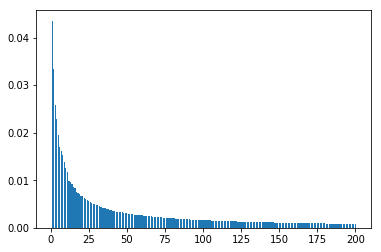

In [206]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 200)
tr,te= dae_data[:13731,:],dae_data[13731:,:]
pca.fit(tr)
import matplotlib.pyplot as plt
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_)
pca.explained_variance_ratio_.sum()

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


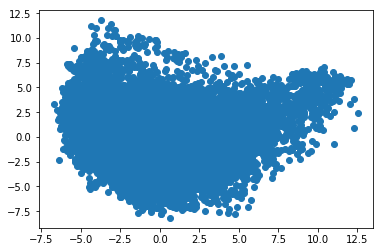

In [137]:
plt.scatter(pca1.iloc[:,0],pca1.iloc[:,1])

In [ ]:
dae_tr = feather.read_dataframe("../data/input/train_DAE.feather")
dae_te = feather.read_dataframe("../data/input/test_DAE.feather")

In [51]:
import sklearn.base
from  bhtsne import tsne
import numpy as np



# 訓練用データを基準にテストデータも標準化


y = tsne(dae_data.astype("float64"),rand_seed=1103,dimensions=3,perplexity=30)

In [39]:
plt.scatter(y[:,2],y[:,0])

NameError: name 'plt' is not defined

In [55]:
new = pd.DataFrame(y,columns=[f"tsne_{i}" for i in range(3)])

In [56]:
new.to_feather("../features/dae_tsne.feather")

In [ ]:
def rank_gauss(df):
    for c in df.columns:
        series = df[c].rank()
        M = series.max()
        m = series.min() 
        series = (series-m)/(M-m)
        series = series - series.mean()
        series = series.apply(erfinv) 
        df[c] = series
    return df

